## Casting a Classifier into a Fully Convolutional Network

Let's take the standard Caffe Reference ImageNet model "CaffeNet" and transform it into a fully convolutional net for efficient, dense inference on large inputs. This model generates a classification map that covers a given input size instead of a single classification. In particular a 8 $\times$ 8 classification map on a 451 $\times$ 451 input gives 64x the output in only 3x the time. The computation exploits a natural efficiency of convolutional network (convnet) structure by amortizing the computation of overlapping receptive fields.

To do so we translate the `InnerProduct` matrix multiplication layers of CaffeNet into `Convolutional` layers. This is the only change: the other layer types are agnostic to spatial size. Convolution is translation-invariant, activations are elementwise operations, and so on. The `fc6` inner product when carried out as convolution by `fc6-conv` turns into a 6 \times 6 filter with stride 1 on `pool5`. Back in image space this gives a classification for each 227 $\times$ 227 box with stride 32 in pixels. Remember the equation for output map / receptive field size, output = (input - kernel_size) / stride + 1, and work out the indexing details for a clear understanding.

The only differences needed in the architecture are to change the fully connected classifier inner product layers into convolutional layers with the right filter size -- 6 x 6, since the reference model classifiers take the 36 elements of `pool5` as input -- and stride 1 for dense classification. Note that the layers are renamed so that Caffe does not try to blindly load the old parameters when it maps layer names to the pretrained model.

In [55]:
# Make sure that caffe is on the python path:
caffe_root = '/home/yuchen/Desktop/caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# Load the original network and extract the fully connected layers' parameters.
net = caffe.Net('./ava_128X128/deploy.prototxt', 
                './ava_128X128/finetune_ava_aesthetic_iter_50000.caffemodel', 
                caffe.TEST)
print net.blobs.keys()
params = ['fc6_ava', 'fc7_ava', 'fc8_ava']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

['data', 'conv1', 'pool1', 'norm1', 'conv2', 'pool2', 'norm2', 'conv3', 'conv4', 'conv5', 'pool5', 'fc6', 'fc7', 'fc8_ava', 'prob']
fc6_ava weights are (256, 2304) dimensional and biases are (256,) dimensional
fc7_ava weights are (256, 256) dimensional and biases are (256,) dimensional
fc8_ava weights are (2, 256) dimensional and biases are (2,) dimensional


Consider the shapes of the inner product parameters. The weight dimensions are the output and input sizes while the bias dimension is the output size.

In [56]:
# Load the fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net('./AVACaffeNet_full_conv.prototxt', 
                          './ava_128X128/finetune_ava_aesthetic_iter_50000.caffemodel',
                          caffe.TEST)

print net_full_conv.blobs.keys()
params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}
for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

['data', 'conv1', 'pool1', 'norm1', 'conv2', 'pool2', 'norm2', 'conv3', 'conv4', 'conv5', 'pool5', 'fc6-conv', 'fc7-conv', 'fc8-conv', 'prob']
fc6-conv weights are (256, 256, 3, 3) dimensional and biases are (256,) dimensional
fc7-conv weights are (256, 256, 1, 1) dimensional and biases are (256,) dimensional
fc8-conv weights are (2, 256, 1, 1) dimensional and biases are (2,) dimensional


The convolution weights are arranged in output $\times$ input $\times$ height $\times$ width dimensions. To map the inner product weights to convolution filters, we could roll the flat inner product vectors into channel $\times$ height $\times$ width filter matrices, but actually these are identical in memory (as row major arrays) so we can assign them directly.

The biases are identical to those of the inner product.

Let's transplant!

In [57]:
for pr, pr_conv in zip(params, params_full_conv):
    print conv_params[pr_conv][0].shape
    print fc_params[pr][0].shape
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

(256, 256, 3, 3)
(256, 2304)
(256, 256, 1, 1)
(256, 256)
(2, 256, 1, 1)
(2, 256)


Next, save the new model weights.

In [58]:
net_full_conv.save('./ava_conv.caffemodel')

To conclude, let's make a classification map from the example cat image and visualize the confidence of "tiger cat" as a probability heatmap. This gives an 8-by-8 prediction on overlapping regions of the 451 $\times$ 451 input.

(988, 7425, 3)


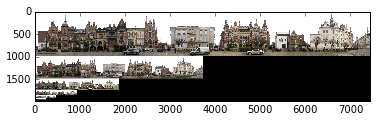

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Image

def mypaste(target, canvus, shift_x, shift_y):
    canvus[shift_x:shift_x+target.shape[0],shift_y:shift_y+target.shape[1],:] = target
    return canvus

im = caffe.io.load_image('./street.jpg')
#print im.shape
pyramid_im = np.zeros((im.shape[0]*2,im.shape[1],3), dtype=float)
#print pyramid_im.shape
mypaste(im, pyramid_im , 0, 0)
shift_x = im.shape[0]
G = im.copy()
for i in xrange(6):
    G = cv2.pyrDown(G)
    mypaste(G, pyramid_im , shift_x, 0)
    shift_x = shift_x + G.shape[0]
plt.imshow(pyramid_im)

#im = pyramid_im
print im.shape

(1, 3, 128, 1024)
(1, 2, 1, 29)


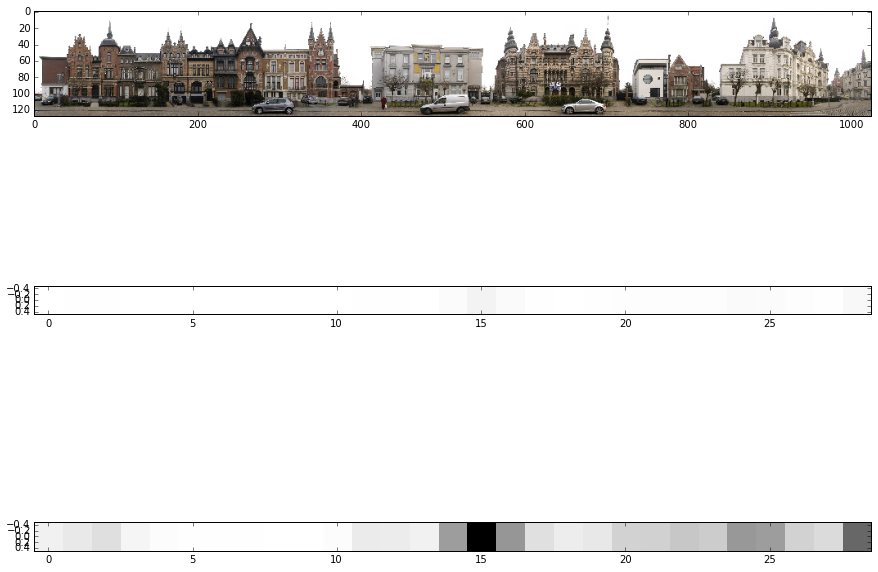

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0)
# load input and configure preprocessing
#im = caffe.io.load_image('./white.png')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
#transformer.set_mean('data', np.load(caffe_root+'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
# maps RGB to BGR as needed for the reference ImageNet model
# because images in lmdb is in BGR while JPEG in RGB
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
print np.asarray([transformer.preprocess('data', im)]).shape
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
#out = net.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
#print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(3, 1, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(3, 1, 2)
plt.imshow(out['prob'][0,1], cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0, vmax=1)
plt.subplot(3, 1, 3)
plt.imshow(out['prob'][0,1], cmap=plt.get_cmap('gray'), interpolation='nearest')

print out['prob'].shape

mpimg.imsave("input.png", transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
mpimg.imsave("heatmap_o.png", out['prob'][0,1], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
mpimg.imsave("heatmap_r.png", out['prob'][0,1], cmap=plt.get_cmap('gray'))

In this way the fully connected layers can be extracted as dense features across an image (see `net_full_conv.blobs['fc6'].data` for instance), which is perhaps more useful than the classification map itself.

Note that this model isn't totally appropriate for sliding-window detection since it was trained for whole-image classification. Nevertheless it can work just fine. Sliding-window training and finetuning can be done by defining a sliding-window ground truth and loss such that a loss map is made for every location and solving as usual. (This is an exercise for the reader.)

*A thank you to Rowland Depp for first suggesting this trick.*

In [66]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

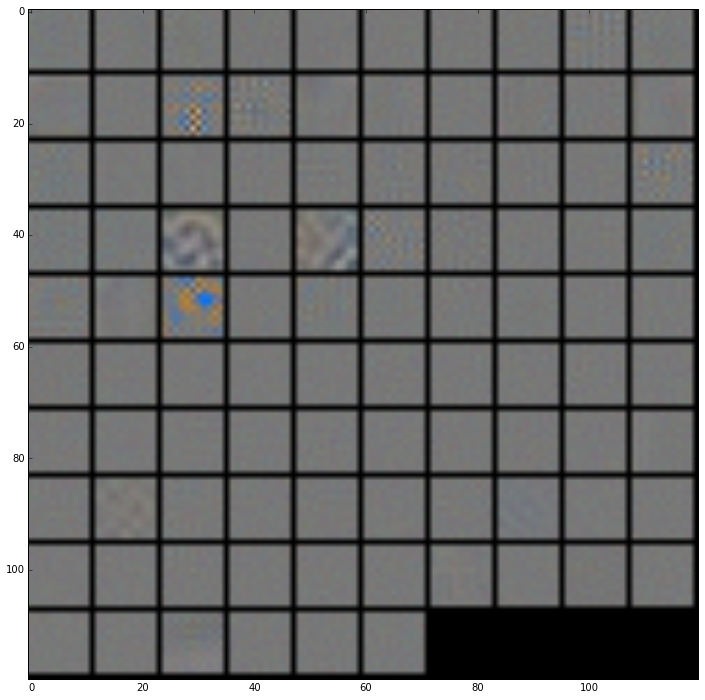

In [67]:
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


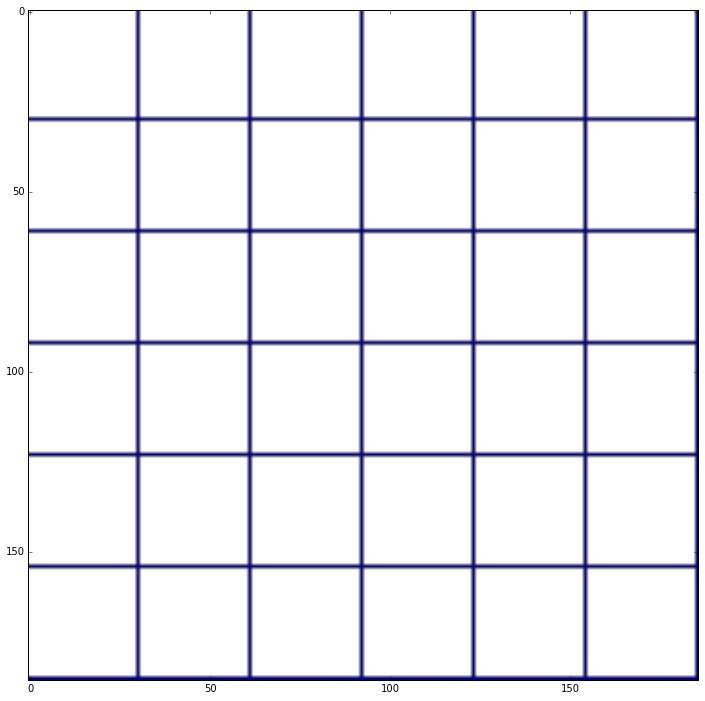

In [68]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)

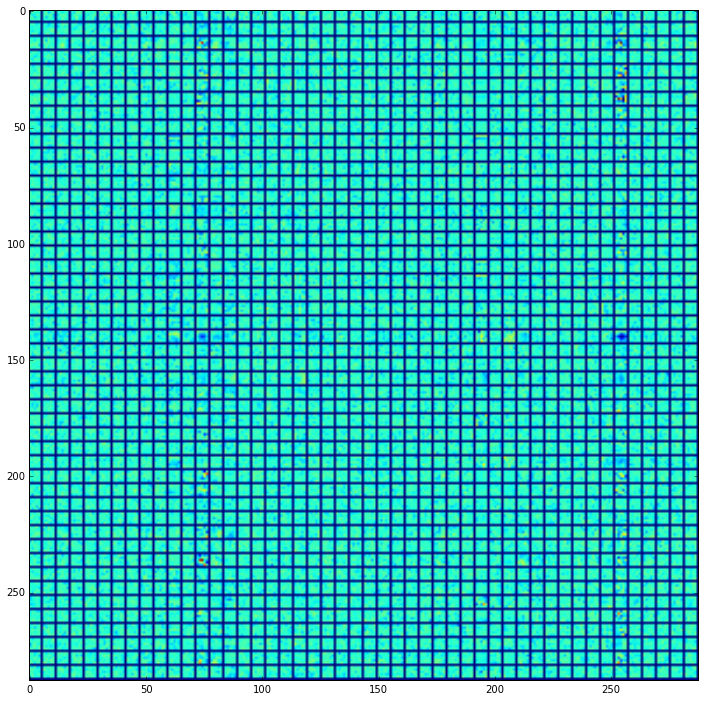

In [69]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))